# Thinking About Data Generating Processes

In this notebook, we are going to demonstrate why thinking about the data generating process can be important.

![TigerPutt](https://media.giphy.com/media/TgMz5yQqqB3VrpMWP8/giphy.gif)

**Note**: This notebook borrows heavily from [this case study](https://mc-stan.org/users/documentation/case-studies/golf.html) in the Stan manual. Many thanks to Andrew Gelman, Mark Broadie, and others for inspiring this exercise.

## The Data

We will be using golf data on whether a golfer makes a putt or not.


Columns are:

* `pid`: A unique identifier that tells us which player took the shot
* `distance`: How many inches there are to the hole
* `made`: Whether the putt went in

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as st
import seaborn as sns
import theano.tensor as tt

%matplotlib inline

In [2]:
data_color = "#3cad13"
lr_color = "#2b63f0"
gm_color = "#e3822d"

In [3]:
putts = pd.read_csv("./putts.csv", index_col=0)

In [4]:
putts.head()

,pid,distance,made
0,2206,45,1
1,2206,124,0
2,2206,185,0
3,2206,103,1
4,2206,175,0


### How often are putts made?

In [5]:
putts = putts.sort_values("distance")

In [6]:
dist_splits = np.array_split(putts["distance"].values, 20)
dist_mean = [d.mean() for d in dist_splits]

made_splits = np.array_split(putts["made"].values, 20)
made_mean = [m.mean() for m in made_splits]

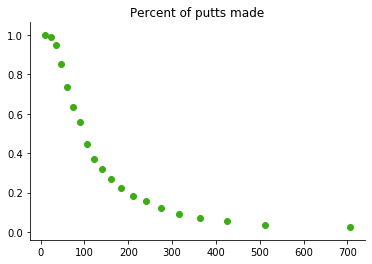

In [7]:
fig, ax = plt.subplots()

ax.scatter(dist_mean, made_mean, color=data_color)

ax.set_title("Percent of putts made")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## The "Standard" Approach

Typically when faced with a binary classification problem, the first thing that one turns to is logistic regression

Our logistic regression model will only be a function of distance.

### Fit the model

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
X = putts.loc[:, ["distance"]].values
y = putts.loc[:, "made"].values

In [10]:
logr = LogisticRegression(solver="lbfgs")
logr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Compare with data

In [13]:
Xlinspace = np.linspace(12.0, 500, 5000)
probs = logr.predict_proba(Xlinspace[:, None])
prob_miss = probs[:, 0]
prob_make = probs[:, 1]

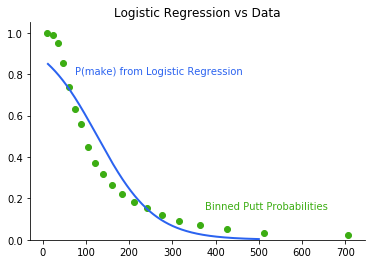

In [14]:
fig, ax = plt.subplots()

ax.plot(Xlinspace, prob_make, color=lr_color, linewidth=2.0)
ax.annotate("P(make) from Logistic Regression", xy=(75, 0.8), color=lr_color)

ax.scatter(dist_mean, made_mean, color=data_color)
ax.annotate("Binned Putt Probabilities", xy=(375, 0.15), color=data_color)

ax.set_title("Logistic Regression vs Data")
ax.set_ylim(0.0, 1.05)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## Modeling the Data Generating Process

Rather than simply choose logistic regression as our model, let's build a model from first principles


### The probability a putt shot goes in?

First, we need to determine the chance of a putt going in. The following excerpt comes directly from the Stan case studies page,

> The graph below shows a simplified sketch of a golf shot. The dotted line represents the angle within which the ball of radius $r$ must be hit so that it falls within the hole of radius $R$. This threshold angle is $\sin^{−1}((R−r)/x)$. The graph, which is not to scale, is intended to illustrate the geometry of the ball needing to go into the hole.
>
> ![putt_image](./putt.png)
>
> The next step is to model human error. We assume that the golfer is attempting to hit the ball completely straight but that many small factors interfere with this goal, so that the actual angle follows a normal distribution centered at 0 with some standard deviation $\sigma$.
>
> ![putt_image](./error.png)
>
> The probability the ball goes in the hole is then the probability that the angle is less than the threshold; that is, $\text{Pr}(|angle| < \sin^{−1}((R−r) / x)) = 2 \Phi \left( \frac{\sin^{−1}((R−r)/x)}{\sigma} \right) - 1$, where $\Phi$ is the cumulative normal distribution function. The only unknown parameter in this model is $\sigma$, the standard deviation of the distribution of shot angles...
>
> Our model then has two parts:
>
> $$y_j \sim \text{Bernoulli}(p_j)$$
> $$p_j = 2 \Phi \left( \frac{\sin^{-1}((R - r)/x)}{\sigma} \right) - 1$$

Let's investigate how $p_j$ changes with $\sigma$

In [15]:
r = 1.68 / 2
R = 4.25 / 2

Text(0.5, 1.0, 'Probability of Making Putt (varying $\\sigma$)')

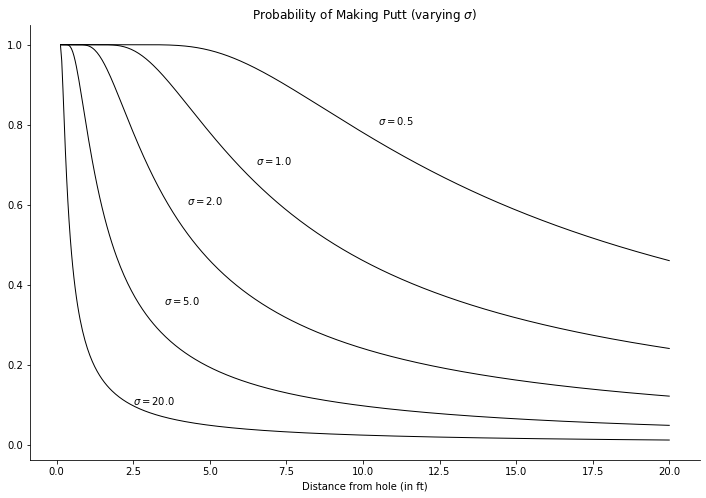

In [16]:
Xvalues = np.linspace(1.0, 20*12, 500)

fig, ax = plt.subplots(figsize=(12, 8))

for sigma in [0.5, 1.0, 2.0, 5.0, 20.0]:
    sigma_radians = np.deg2rad(sigma)
    inner_stuff = np.arcsin((R - r) / Xvalues) / sigma_radians
    p_j = 2*st.norm().cdf(inner_stuff) - 1

    ax.plot(Xvalues/12, p_j, color="k", linewidth=1.)

ax.annotate(r"$\sigma = 0.5$", (10.5, 0.8))
ax.annotate(r"$\sigma = 1.0$", (6.5, 0.7))
ax.annotate(r"$\sigma = 2.0$", (4.25, 0.6))
ax.annotate(r"$\sigma = 5.0$", (3.5, 0.35))
ax.annotate(r"$\sigma = 20.0$", (2.5, 0.1))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlabel("Distance from hole (in ft)")
ax.set_title(r"Probability of Making Putt (varying $\sigma$)")

Now, we translate the model that has been built into a Bayesian model

In [17]:
Xb = putts.loc[:, "distance"].copy().values
yb = putts.loc[:, "made"].copy().values

In [18]:
Xb_tilde = np.maximum((R - r) + 1e-2, Xb)

In [19]:
m = pm.Model()

with m:

    # Prior on sigma
    sigma = pm.HalfNormal("sigma", sigma=15.0)

    # Convert sigma to radians
    sigma_radians = sigma * (math.pi/180)

    # Compute probability of making it
    _inner = tt.arcsin((R - r) / Xb_tilde) / sigma_radians
    p_j = 2*pm.math.exp(
        pm.distributions.dist_math.normal_lcdf(0.0, 1.0, _inner)
    ) - 1.0

    # Determine whether successful
    putt_make = pm.Bernoulli("putt_make", p=p_j, observed=yb)


In [21]:
with m:
    trace = pm.sample(2500, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:45<00:00, 39.95draws/s]


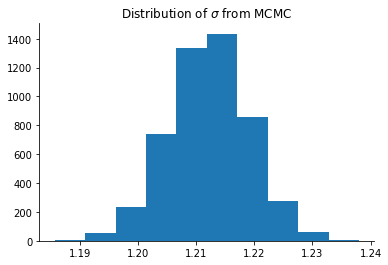

In [22]:
fig, ax = plt.subplots()

ax.hist(trace["sigma"])

ax.set_title(r"Distribution of $\sigma$ from MCMC")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [23]:
Xvalues = np.linspace(2.0, 700, 500)

sigma_radians = np.deg2rad(trace["sigma"])
inner_stuff = np.arcsin((R - r) / Xvalues[None, :]) / sigma_radians[:, None]
p_j = 2 * st.norm().cdf(inner_stuff) - 1


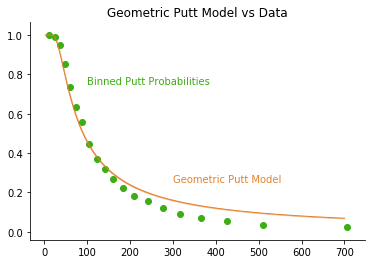

In [24]:
p_j_mean = np.mean(p_j, axis=0)
p_j_5 = np.quantile(p_j, 0.01, axis=0)
p_j_95 = np.quantile(p_j, 0.99, axis=0)

fig, ax = plt.subplots()

ax.plot(Xvalues, p_j_mean, color=gm_color, linewidth=1.0)
ax.fill_between(Xvalues, p_j_5, p_j_95, color=gm_color, alpha=0.35)
ax.annotate("Geometric Putt Model", xy=(300, 0.25), color=gm_color)

ax.scatter(dist_mean, made_mean, color=data_color)
ax.annotate("Binned Putt Probabilities", xy=(100, 0.75), color=data_color)

ax.set_title("Geometric Putt Model vs Data")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## Comparing Logistic Regression and Geometric Putt Model

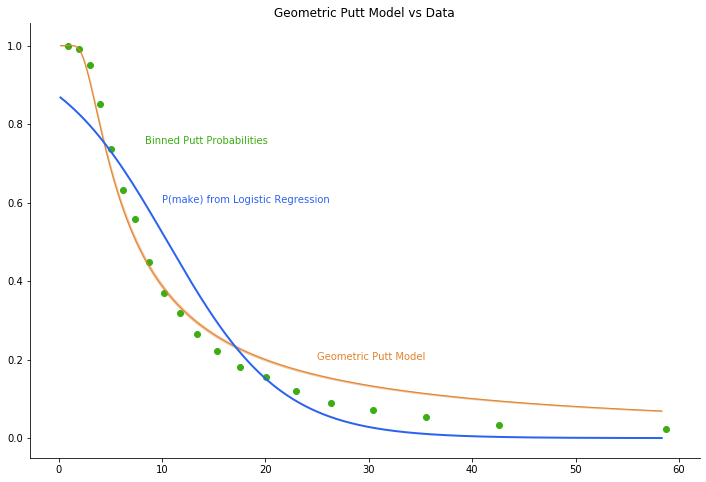

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(Xvalues / 12, p_j_mean, color=gm_color, linewidth=1.0)
ax.fill_between(Xvalues / 12, p_j_5, p_j_95, color=gm_color, alpha=0.35)
ax.annotate("Geometric Putt Model", xy=(300 / 12, 0.2), color=gm_color)

ax.plot(
    Xvalues / 12, logr.predict_proba(Xvalues[:, None])[:, 1],
    color=lr_color, linewidth=2.0
)
ax.annotate("P(make) from Logistic Regression", xy=(120 / 12, 0.6), color=lr_color)

ax.scatter(np.array(dist_mean) / 12, made_mean, color=data_color)
ax.annotate("Binned Putt Probabilities", xy=(100 / 12, 0.75), color=data_color)

ax.set_title("Geometric Putt Model vs Data")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### Why are we missing the long putts?

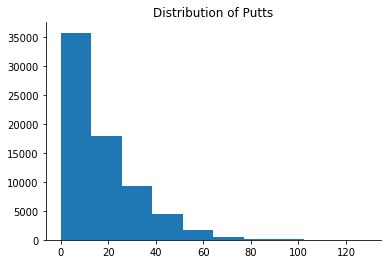

In [33]:
fig, ax = plt.subplots()

ax.hist(putts["distance"].values / 12)

ax.set_title("Distribution of Putts")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)